In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [8]:
df = pd.read_csv('./heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [9]:
TARGET_COL = "HeartDisease"
df.columns = [c.strip() for c in df.columns]

# NaN the abnormal 
for col in ["Cholesterol", "RestingBP"]:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)
if "Oldpeak" in df.columns:
    df.loc[df["Oldpeak"] < 0, "Oldpeak"] = np.nan

#for check 
print(f"count of RestiongBP <=0 :  {(df['RestingBP'] <= 0).sum()}")
print(f"count of Cholesterol <=0 :  {(df['Cholesterol'] <= 0).sum()}")
print(f"count of Oldpeak <0 :  {(df['Oldpeak'] < 0).sum()}")

# recognize column type
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != TARGET_COL]
cat_cols = [c for c in df.columns if (not pd.api.types.is_numeric_dtype(df[c])) and c != TARGET_COL]

print("Target:", TARGET_COL)
print("Numeric features:", num_cols)
print("Categorical features:", cat_cols)

count of RestiongBP <=0 :  0
count of Cholesterol <=0 :  0
count of Oldpeak <0 :  0
Target: HeartDisease
Numeric features: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Categorical features: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [10]:
num_cols.remove('FastingBS')  # it is categorical, remove it from numerical
cat_cols.append('FastingBS')  # add it into categorical column

In [11]:
desc = df[num_cols].describe().T
print("\n[Univariate] Numeric describe:\n", desc)


[Univariate] Numeric describe:
              count        mean        std   min     25%    50%    75%    max
Age          918.0   53.510893   9.432617  28.0   47.00   54.0   60.0   77.0
RestingBP    917.0  132.540894  17.999749  80.0  120.00  130.0  140.0  200.0
Cholesterol  746.0  244.635389  59.153524  85.0  207.25  237.0  275.0  603.0
MaxHR        918.0  136.809368  25.460334  60.0  120.00  138.0  156.0  202.0
Oldpeak      905.0    0.914254   1.046944   0.0    0.00    0.6    1.5    6.2


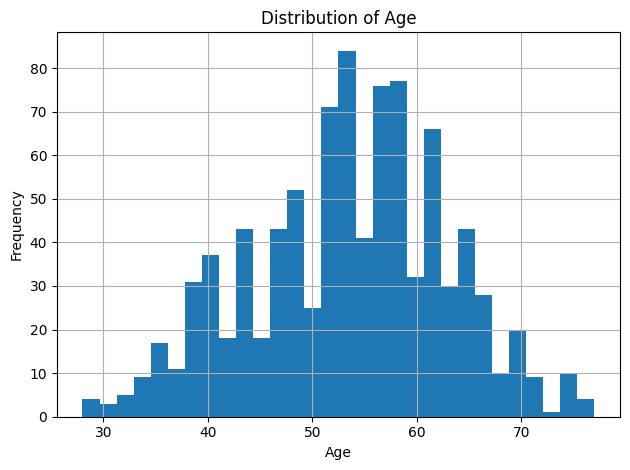

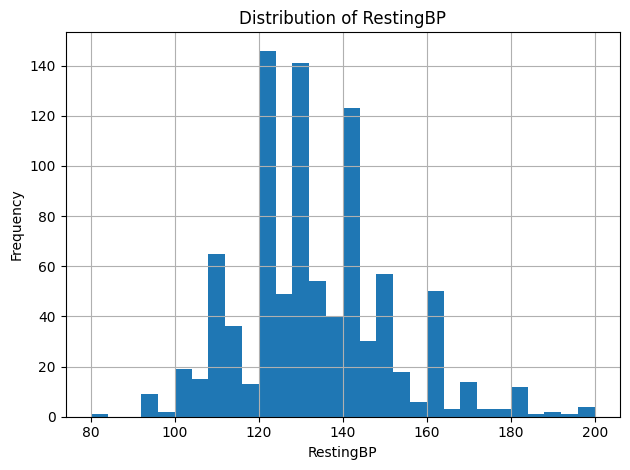

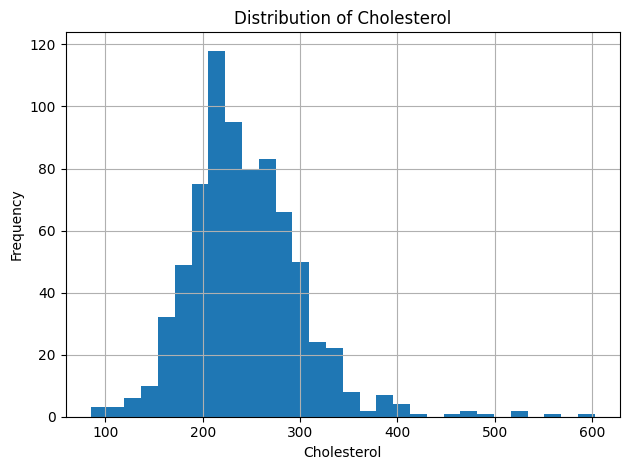

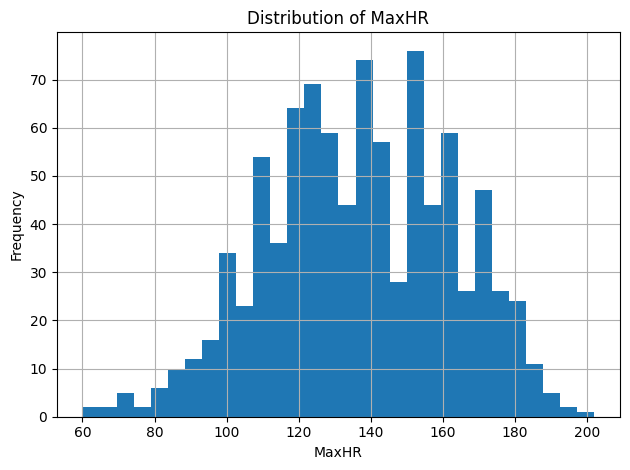

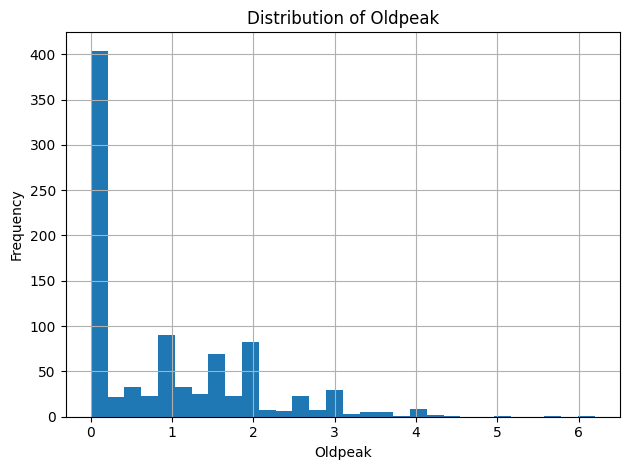

In [12]:
# numerical column distribution
for c in num_cols:
    plt.figure()
    df[c].dropna().hist(bins=30)
    plt.title(f"Distribution of {c}")
    plt.xlabel(c)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


[Univariate] Categorical Sex value counts:
Sex
M    725
F    193
Name: count, dtype: int64


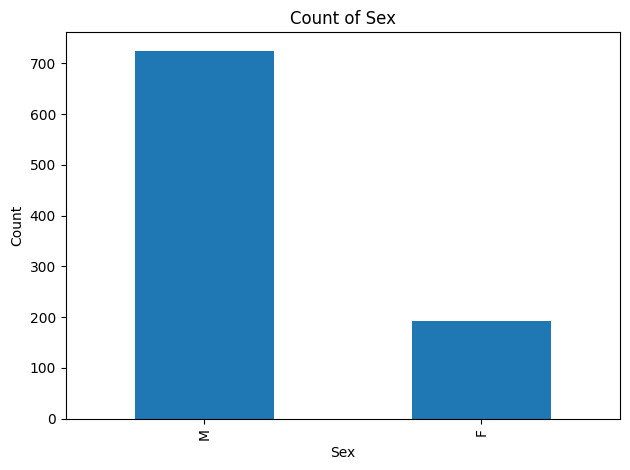


[Univariate] Categorical ChestPainType value counts:
ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64


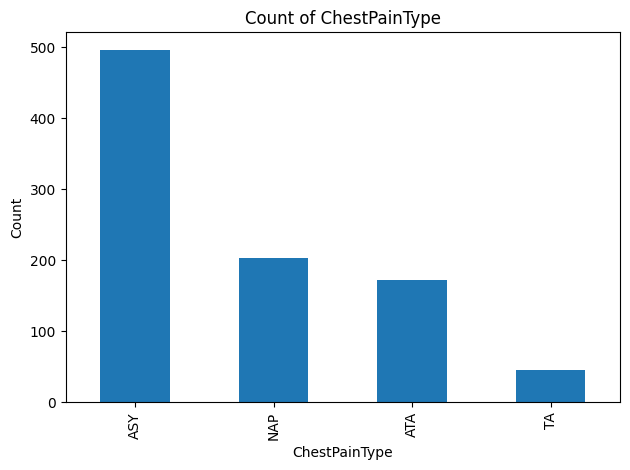


[Univariate] Categorical RestingECG value counts:
RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64


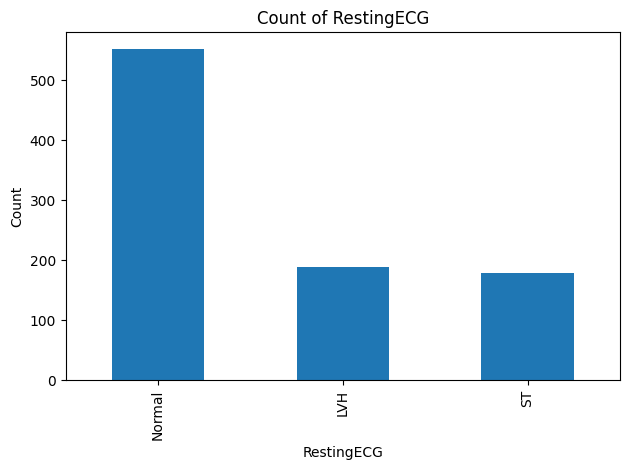


[Univariate] Categorical ExerciseAngina value counts:
ExerciseAngina
N    547
Y    371
Name: count, dtype: int64


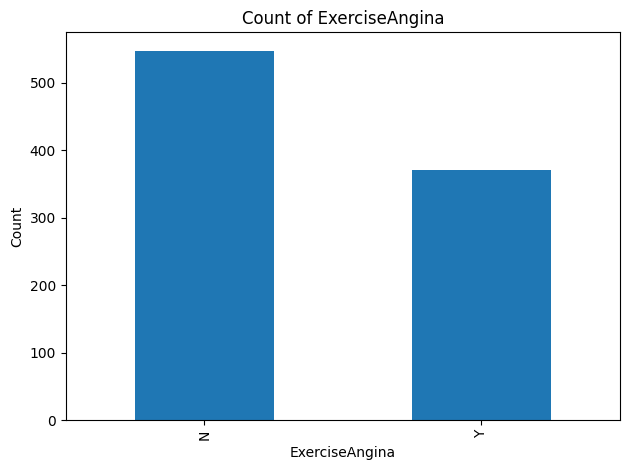


[Univariate] Categorical ST_Slope value counts:
ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64


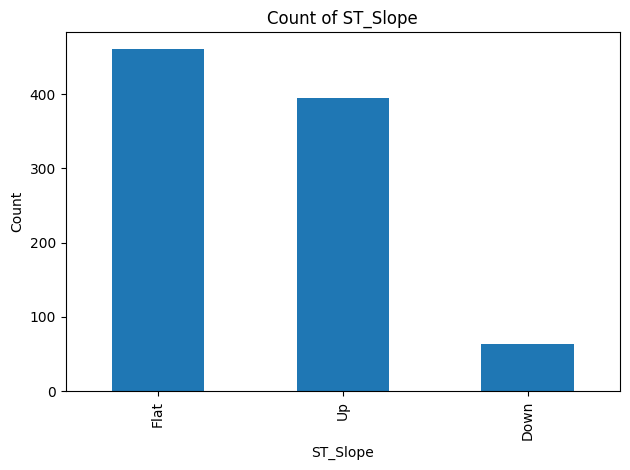


[Univariate] Categorical FastingBS value counts:
FastingBS
0    704
1    214
Name: count, dtype: int64


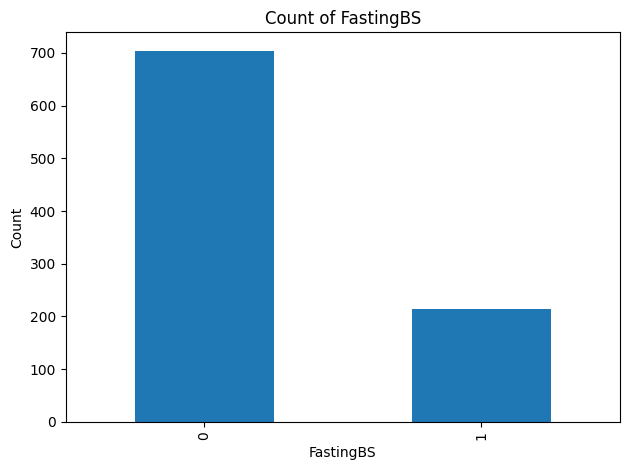

In [13]:
for c in cat_cols:
    vc = df[c].value_counts(dropna=False)
    print(f"\n[Univariate] Categorical {c} value counts:\n{vc}")
    plt.figure()
    vc.plot(kind="bar")
    plt.title(f"Count of {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

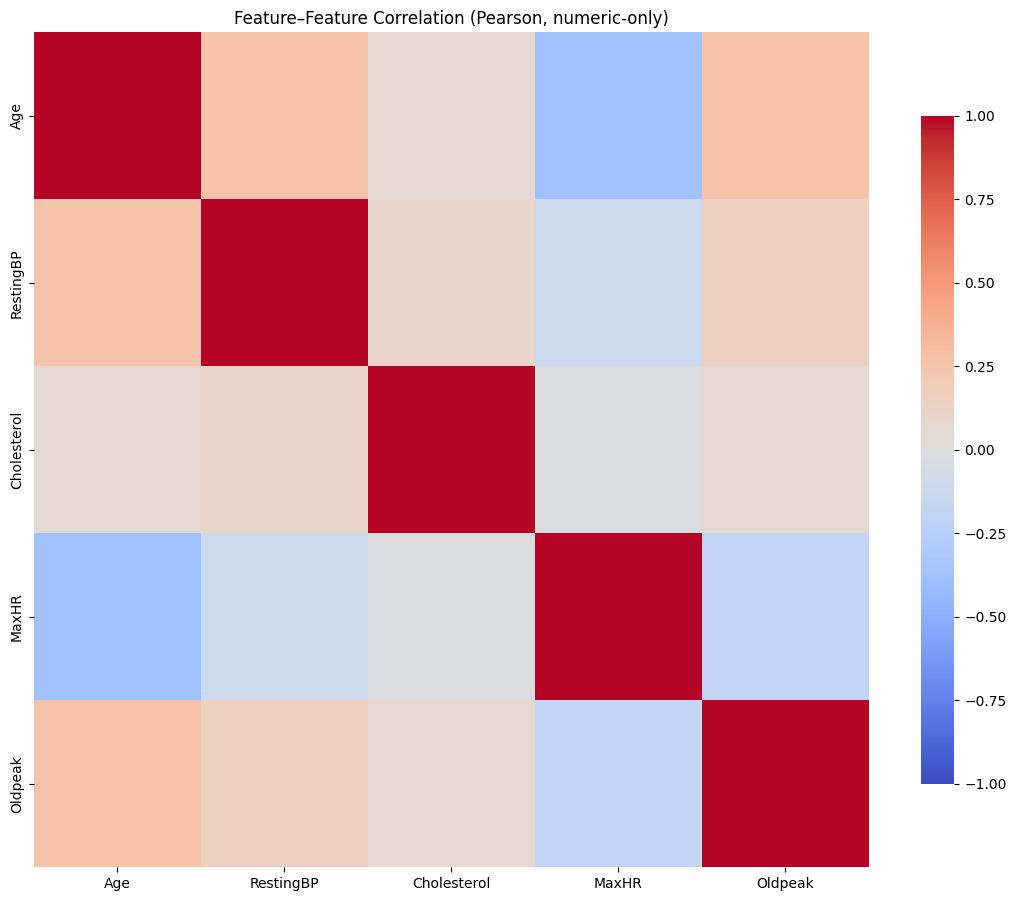

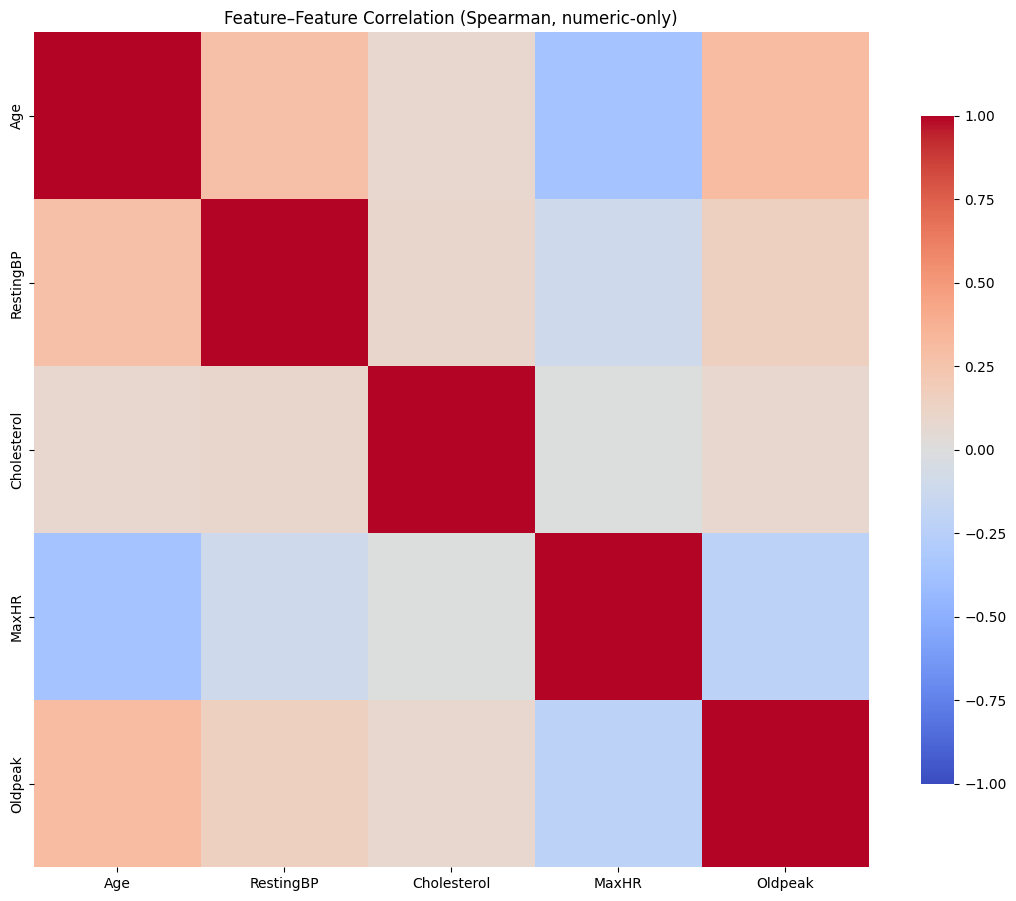

In [14]:
corr_pearson  = df[num_cols].corr(method="pearson")
corr_spearman = df[num_cols].corr(method="spearman")

plt.figure(figsize=(11, 9))
sns.heatmap(corr_pearson, cmap="coolwarm", vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .8})
plt.title("Feature–Feature Correlation (Pearson, numeric-only)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(11, 9))
sns.heatmap(corr_spearman, cmap="coolwarm", vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .8})
plt.title("Feature–Feature Correlation (Spearman, numeric-only)")
plt.tight_layout()
plt.show()

In [15]:
def top_k_pairs(corr_df, k=10):
    c = corr_df.abs().where(~np.eye(corr_df.shape[0], dtype=bool))  # remove diagonal
    pairs = (
        c.unstack()
         .dropna()
         .sort_values(ascending=False)
    )
    # Deduplicate symmetrical pairs (A,B) and (B,A)
    seen = set()
    top = []
    for (a, b), v in pairs.items():
        key = tuple(sorted([a, b]))
        if a == b or key in seen:
            continue
        seen.add(key)
        top.append((a, b, corr_df.loc[a, b], abs(corr_df.loc[a, b])))
        if len(top) >= k:
            break
    return pd.DataFrame(top, columns=["Feature A", "Feature B", "Pearson", "|Pearson|"])

top_pairs = top_k_pairs(corr_pearson, k=12)
print("\n[Top correlated feature pairs by |Pearson|] (numeric-only)")
print(top_pairs.to_string(index=False))


[Top correlated feature pairs by |Pearson|] (numeric-only)
  Feature A   Feature B   Pearson  |Pearson|
      MaxHR         Age -0.382045   0.382045
        Age     Oldpeak  0.263086   0.263086
        Age   RestingBP  0.263084   0.263084
      MaxHR     Oldpeak -0.180993   0.180993
  RestingBP     Oldpeak  0.151950   0.151950
      MaxHR   RestingBP -0.109693   0.109693
Cholesterol   RestingBP  0.095939   0.095939
Cholesterol         Age  0.058758   0.058758
Cholesterol     Oldpeak  0.056824   0.056824
      MaxHR Cholesterol -0.019856   0.019856
